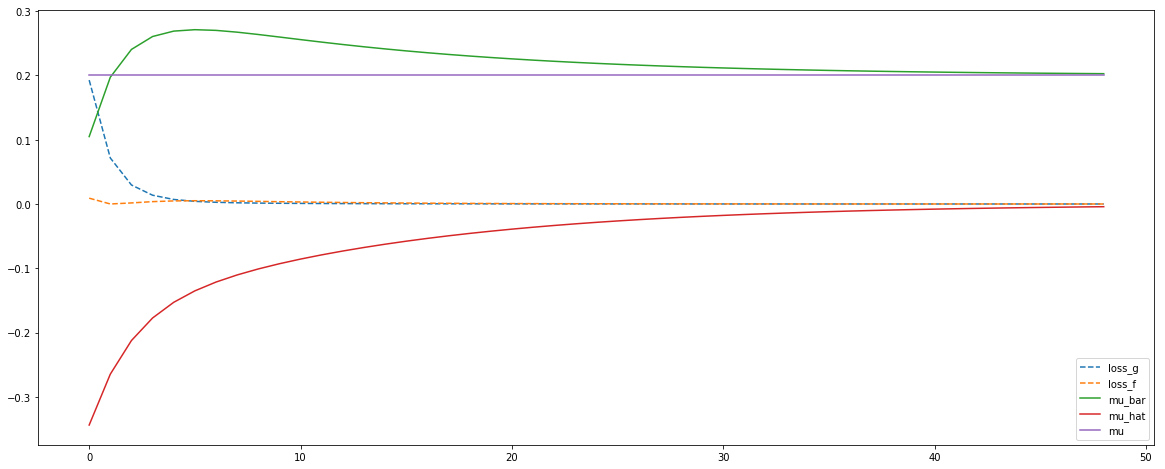

In [40]:
from __future__ import print_function
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from torchviz import make_dot

class G(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=5, t_sample=1):
        super(G, self).__init__()
        
        self.g1 = nn.Linear(input_size * t_sample, hidden_size)
        self.g2 = nn.Linear(hidden_size, output_size * t_sample)
        self.act = nn.Tanh()

    def forward(self, x):
        x = F.relu(self.g1(x))
        x = self.g2(x)
        x = self.act(x)
        return x
    
class Unit(nn.Module):
    def __init__(self, mu_size, mu_next_size):
        super(Unit, self).__init__()
        self.g = G(mu_next_size, mu_size)
        self.f = G(mu_size, mu_size)
        lr = 0.05
        self.optimizer_g = optim.SGD(self.g.parameters(), lr=lr, momentum=0)
        self.optimizer_f = optim.SGD(self.f.parameters(), lr=lr, momentum=0)
        self.previous_mu = None

    def forward(self, mu, mu_next):
        #print('self.mu0         = {}'.format(mu))

        self.mu_bar = self.f(mu)
        #print('self.mu_bar      = {}'.format(self.mu_bar))

        self.mu_hat = self.g(mu_next)
        #print('self.mu1         = {}'.format(mu_next))
        #print('self.mu_hat      = {}'.format(self.mu_hat))
        #print('-----------------')
        
    def t(self, arr, device):
        return torch.tensor(arr).to(device)

    def step(self, mu, mu_next, device):
        if self.previous_mu is not None:
            self.g.train()
            self.f.train()

            self.optimizer_g.zero_grad()
            self.optimizer_f.zero_grad()

            self.forward(mu, mu_next)

            #print('self.mu_hat = {}'.format(self.mu_hat))
            #print('mu - self.mu_bar = {}'.format(mu - self.mu_bar))

            loss_g = F.mse_loss(self.mu_hat, mu - self.mu_bar)
            loss_g.backward(retain_graph=True)
            self.optimizer_g.step()

            loss_f = F.mse_loss(self.mu_bar, mu)
            loss_f.backward()
            self.optimizer_f.step()
            
            return [loss_g, loss_f, self.mu_bar, self.mu_hat, mu]

        self.previous_mu = mu
        return [None, None]



use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
unit = Unit(mu_size=1, mu_next_size=1)
loss_history = []

for _ in range(50):
    mu = torch.tensor([0.2]).to(device)
    mu_next = torch.tensor([1.]).to(device)
    loss = unit.step(mu, mu_next, device)
    if loss[0] is not None:
        loss_history.append(loss)

loss_history = np.array(loss_history)
fig = plt.figure(figsize=(20,8))
plt.plot(loss_history[:, 0],"--",label='loss_g')
plt.plot(loss_history[:, 1],"--",label='loss_f')
plt.plot(loss_history[:, 2],"-",label='mu_bar')
plt.plot(loss_history[:, 3],"-",label='mu_hat')
plt.plot(loss_history[:, 4],"-",label='mu')

plt.legend()
plt.show()